# First patient prediction

In [1]:
!pip install opencv-python

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model

from joblib import dump, load

import re

You should consider upgrading via the '/home/adduser/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


## Load model

In [28]:
# import model (labeled CT data)
model_labeledCT = load_model('../models/model_labeled_ct_15epochs')

## Read CT images + grayscale + resize

In [15]:
def read_ct_img_bydir(target_dir):
    img=cv2.imdecode(np.fromfile(target_dir,dtype=np.uint8),cv2.IMREAD_GRAYSCALE)
    #img = corp_margin(img)
    #img=cv2.resize(img,(200,200))
    
    return img

## Get paths from all patient folders

In [5]:
def get_data_paths(main_dir):
    ct_paths = list()
    patient_ids = list()
    
    for dirs in os.listdir(main_dir):

        target_dir = f'../raw_data/CT_data/{dirs}/'
        sub_dir = os.listdir(target_dir)
        target_dir = target_dir+sub_dir[0]+'/'

        ct_paths.append(target_dir)
        patient_ids.append(dirs)
        
    return ct_paths

    #     for file in os.listdir(target_dir):
    #         if file.endswith(".jpg"):
    #             ct_paths.append(os.path.join(target_dir, file))

## Get data from one patient and store in array

In [6]:
def get_patient_data(data_path):
    '''Loads raw data from image names of each class folder and assigns a label to it.'''
    
    target_dir=data_path

    target_list=[target_dir+file for file in os.listdir(target_dir)]

    X=np.array([read_ct_img_bydir(file) for file in target_list])[:,:,:,np.newaxis]

    return X

## Assign classification to prediction

In [7]:
def classify_prediction(prediction):
    
    y_pred_class = np.rint(prediction)
    classification = -999
    
    ni = y_pred_class[:,0].sum()
    pos = y_pred_class[:,1].sum()
    neg = y_pred_class[:,2].sum()
    
    if neg > pos:
        classification = 2 #negative
    elif pos > neg:
        classification = 1 #positive

#     if pos > 0:
#         classification = 1 #positive
#     elif pos <= 0:
#         classification = 2 #negative
    
    return classification, ni, pos, neg

## Extract patient ID from path

In [8]:
def get_patient_id(path):
    pattern = "Patient *[0-9]*"
    substring = re.search(pattern, path).group(0)
    return substring

## Set main_dir

In [9]:
main_dir = f'../raw_data/CT_data/'

ct_paths = get_data_paths(main_dir)

print(ct_paths)

['../raw_data/CT_data/Patient 587/CT/', '../raw_data/CT_data/Patient 396/CT/', '../raw_data/CT_data/Patient 560/CT/', '../raw_data/CT_data/Patient 311/CT/', '../raw_data/CT_data/Patient 414/CT/', '../raw_data/CT_data/Patient 387/CT/', '../raw_data/CT_data/Patient 416/CT/', '../raw_data/CT_data/Patient 565/CT/', '../raw_data/CT_data/Patient 1361/CT/', '../raw_data/CT_data/Patient 348/CT/', '../raw_data/CT_data/Patient 563/CT/', '../raw_data/CT_data/Patient 260/CT/', '../raw_data/CT_data/Patient 562/CT/', '../raw_data/CT_data/Patient 564/CT/', '../raw_data/CT_data/Patient 397/CT/', '../raw_data/CT_data/Patient 413/CT/', '../raw_data/CT_data/Patient 516/CT/', '../raw_data/CT_data/Patient 426/CT/', '../raw_data/CT_data/Patient 405/CT/', '../raw_data/CT_data/Patient 459/CT/', '../raw_data/CT_data/Patient 58/CT/', '../raw_data/CT_data/Patient 569/CT/', '../raw_data/CT_data/Patient 561/CT/', '../raw_data/CT_data/Patient 471/CT/', '../raw_data/CT_data/Patient 302/CT/', '../raw_data/CT_data/Pat

In [35]:
ct_paths;

## Create list with all patient IDs

In [10]:
pt_id_list = list()

for path in ct_paths:
    patient_id = get_patient_id(path)
    pt_id_list.append(patient_id)
    

## Load model, get prediction & classification, create DataFrame

In [37]:
predictions = pd.DataFrame()
predictions['patient_id']=''
predictions['prediction']=''
predictions['niCT_slices']=''
predictions['pCT_slices']=''
predictions['nCT_slices']=''

for path in ct_paths:
    X = get_patient_data(path)
    print('Processing: ',path)
    y_pred = model_labeledCT.predict(X)

    patient_id = get_patient_id(path)
    
    classification, ni, pos, neg = classify_prediction(y_pred)
    total_ct = int(ni) + int(pos) + int(neg)
    #df = df.append({'a':1, 'b':2}, ignore_index=True)
    predictions = predictions.append({'patient_id': patient_id, 'prediction': classification, 'niCT_slices': ni, 'pCT_slices': pos,'nCT_slices':neg, 'total_CT_slices': total_ct}, ignore_index = True)    

Processing:  ../raw_data/CT_data/Patient 1264/CT/
Processing:  ../raw_data/CT_data/Patient 534/CT/
Processing:  ../raw_data/CT_data/Patient 1200/CT/
Processing:  ../raw_data/CT_data/Patient 148/CT/
Processing:  ../raw_data/CT_data/Patient 794/CT/
Processing:  ../raw_data/CT_data/Patient 1215/CT/
Processing:  ../raw_data/CT_data/Patient 375/CT/
Processing:  ../raw_data/CT_data/Patient 1184/CT/
Processing:  ../raw_data/CT_data/Patient 777/CT/
Processing:  ../raw_data/CT_data/Patient 1177/CT/
Processing:  ../raw_data/CT_data/Patient 121/CT/
Processing:  ../raw_data/CT_data/Patient 1186/CT/
Processing:  ../raw_data/CT_data/Patient 145/CT/
Processing:  ../raw_data/CT_data/Patient 533/CT/
Processing:  ../raw_data/CT_data/Patient 1180/CT/
Processing:  ../raw_data/CT_data/Patient 1275/CT/
Processing:  ../raw_data/CT_data/Patient 535/CT/
Processing:  ../raw_data/CT_data/Patient 1188/CT/
Processing:  ../raw_data/CT_data/Patient 1217/CT/
Processing:  ../raw_data/CT_data/Patient 1179/CT/
Processin

In [38]:
predictions.sort_values(by='prediction', ascending=True).reset_index(drop=True)

,patient_id,prediction,niCT_slices,pCT_slices,nCT_slices,total_CT_slices
25,Patient 1265,1,45.0,89.0,20.0,154.0
8,Patient 777,1,91.0,131.0,9.0,231.0
12,Patient 145,1,90.0,238.0,16.0,344.0
0,Patient 1264,2,55.0,0.0,136.0,191.0
26,Patient 1176,2,81.0,0.0,87.0,168.0
24,Patient 1182,2,63.0,0.0,91.0,154.0
23,Patient 1187,2,41.0,0.0,128.0,169.0
22,Patient 1185,2,97.0,0.0,130.0,227.0
21,Patient 144,2,17.0,0.0,46.0,63.0
20,Patient 1181,2,50.0,0.0,110.0,160.0


# Data Exploration

## Test on 3 patients

(151, 200, 200, 1)
(151, 3)


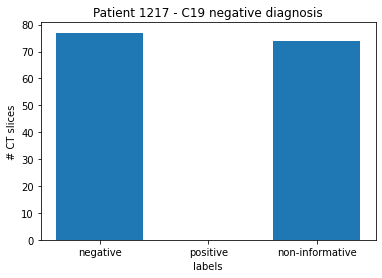

In [39]:
X1 = get_patient_data('../raw_data/CT_data/Patient 1217/CT/')

print(X1.shape)

y1_pred = model_labeledCT.predict(X1)
print(y1_pred.shape)

y1_pred_class = np.rint(y1_pred)
y1_pred_class.shape

y1_pred_class = y1_pred_class.astype(int);
y1_pred_class.shape

# number negative CTs
neg1 = y1_pred_class[:,2].sum()
neg1

# number positive CTs
pos1 = y1_pred_class[:,1].sum()
pos1

# number non-informative CTs
ni1 = y1_pred_class[:,0].sum()
ni1

plt.bar(['negative', 'positive', 'non-informative'],[neg1, pos1, ni1])
plt.title('Patient 1217 - C19 negative diagnosis');
plt.ylabel('# CT slices');
plt.xlabel('labels');

(70, 200, 200, 1)


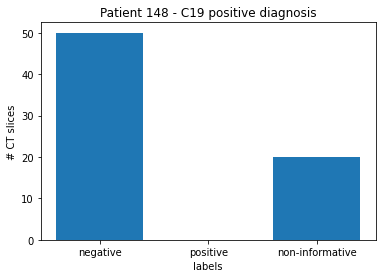

In [40]:
X2 = get_patient_data('../raw_data/CT_data/Patient 148/CT/')

print(X2.shape)

y2_pred = model_labeledCT.predict(X2)

y2_pred_class = np.rint(y2_pred)
y2_pred_class[:,2].sum()

y2_pred_class = y2_pred_class.astype(int);
y2_pred_class;

# number negative CTs
neg2 = y2_pred_class[:,2].sum()

# number positive CTs
pos2 = y2_pred_class[:,1].sum()

# number non-informative CTs
ni2 = y2_pred_class[:,0].sum()

plt.bar(['negative', 'positive', 'non-informative'],[neg2, pos2, ni2])
plt.title('Patient 148 - C19 positive diagnosis');
plt.ylabel('# CT slices');
plt.xlabel('labels');

(200, 200, 200, 1)


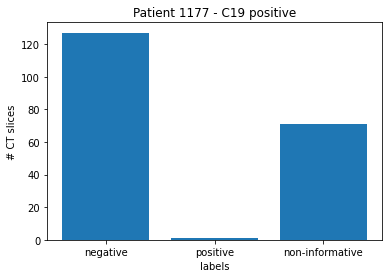

In [41]:
X3 = get_patient_data('../raw_data/CT_data/Patient 1177/CT/')

print(X3.shape)

y3_pred = model_labeledCT.predict(X3)

y3_pred_class = np.rint(y3_pred)

y3_pred_class = y3_pred_class.astype(int);
y3_pred_class.shape

# number negative CTs
neg3 = y3_pred_class[:,2].sum()

# number positive CTs
pos3 = y3_pred_class[:,1].sum()

# number non-informative CTs
ni3 = y3_pred_class[:,0].sum()

plt.bar(['negative', 'positive', 'non-informative'],[neg3, pos3, ni3])
plt.title('Patient 1177 - C19 positive');
plt.ylabel('# CT slices');
plt.xlabel('labels');

In [42]:
#test = list(y1_pred_class)

In [43]:
#y_pred_class.sum()

In [48]:
from google.cloud import storage
from os.path import join, dirname
from dotenv import load_dotenv
import os
from oauth2client.service_account import ServiceAccountCredentials
from PIL import Image
import requests

ModuleNotFoundError: No module named 'dotenv'

In [49]:
pip install dotenv

    ERROR: Command errored out with exit status 1:
     command: /home/adduser/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ahh9e83x/dotenv_5cc2dcd70c9e4dde9141f0d716b15eec/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ahh9e83x/dotenv_5cc2dcd70c9e4dde9141f0d716b15eec/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-qff_i7eh
         cwd: /tmp/pip-install-ahh9e83x/dotenv_5cc2dcd70c9e4dde9141f0d716b15eec/
    Complete output (1589 lines):
        ERROR: Command errored out with exit status 1:
         command: /home/adduser/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/p

         command: /home/adduser/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-wheel-xlz98btp/distribute_7af417ac62a148988e55e7fc7b324a17/setup.py'"'"'; __file__='"'"'/tmp/pip-wheel-xlz98btp/distribute_7af417ac62a148988e55e7fc7b324a17/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-2r1zlf4s
             cwd: /tmp/pip-wheel-xlz98btp/distribute_7af417ac62a148988e55e7fc7b324a17/
        Complete output (10 lines):
        Traceback (most recent call last):
          File "<string>", line 1, in <module>
          File "/tmp/pip-wheel-xlz98btp/distribute_7af417ac62a148988e55e7fc7b324a17/setuptools/__init__.py", line 2, in <module>
            from setupt

    ERROR: Command errored out with exit status 1:
     command: /home/adduser/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ahh9e83x/dotenv_8aa391deb60140f0a28af4e93f399690/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ahh9e83x/dotenv_8aa391deb60140f0a28af4e93f399690/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-8qjtsg39
         cwd: /tmp/pip-install-ahh9e83x/dotenv_8aa391deb60140f0a28af4e93f399690/
    Complete output (1589 lines):
        ERROR: Command errored out with exit status 1:
         command: /home/adduser/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/p

    ERROR: Command errored out with exit status 1:
     command: /home/adduser/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ahh9e83x/dotenv_90db4d4dacb74122a33dc82d130908e9/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ahh9e83x/dotenv_90db4d4dacb74122a33dc82d130908e9/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-wpid0t6l
         cwd: /tmp/pip-install-ahh9e83x/dotenv_90db4d4dacb74122a33dc82d130908e9/
    Complete output (31 lines):
    Traceback (most recent call last):
      File "/tmp/pip-install-ahh9e83x/dotenv_90db4d4dacb74122a33dc82d130908e9/distribute_setup.py", line 150, in use_setuptools
        raise ImportError
    ImportError


In [50]:
def preproc_before_pred(img):
    img=cv2.imread(img)
    img=cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img,(200,200))
    return img

In [51]:
def get_files_from_storage(file_names):
    #get files from google storage
    images = []
    if len(file_names)>0:
        for file_name in file_names:
            storage_client = storage.Client.from_service_account_json(json_credentials_path='batch-606-covid-19-5d766c13ace0.json')
            bucket = storage_client.get_bucket('bucket-covid-19')
            blob = bucket.blob(file_name)
            images.append(blob)
        return images 
    else:
        return None

In [52]:
y = ['image_number(7567).jpg']
x = get_files_from_storage(y)

FileNotFoundError: [Errno 2] No such file or directory: 'batch-606-covid-19-5d766c13ace0.json'

In [47]:
v = var.download_to_filename('temp.jpeg')

NameError: name 'var' is not defined

In [ ]:
preproc_before_pred('temp.jpeg')

In [53]:
ar = [1,0,2]


In [54]:
ar[0]

1

In [2]:
# import model (labeled CT data)
model_labeledCT_500 = load_model('../models/model_500')

In [3]:
y_pred = model_labeledCT_500('../raw_data/Patient_168')

TypeError: Inputs to a layer should be tensors. Got: ../raw_data/Patient_168

(419, 512, 512, 1)


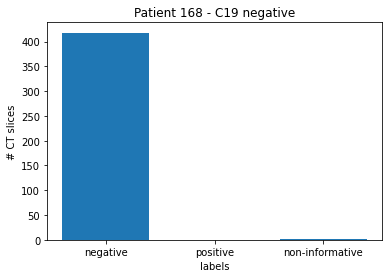

In [22]:
X3 = get_patient_data('../raw_data/CT_data/Patient 432/CT/')

print(X3.shape)

y3_pred = model_labeledCT_500.predict(X3)

y3_pred_class = np.rint(y3_pred)


y3_pred_class = y3_pred_class.astype(int);
y3_pred_class.shape

# number negative CTs
neg3 = y3_pred_class[:,2].sum()

# number positive CTs
pos3 = y3_pred_class[:,1].sum()

# number non-informative CTs
ni3 = y3_pred_class[:,0].sum()

plt.bar(['negative', 'positive', 'non-informative'],[neg3, pos3, ni3])
plt.title('Patient 168 - C19 negative');
plt.ylabel('# CT slices');
plt.xlabel('labels');

In [23]:
y3_pred_class

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [24]:
y3_pred

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [37]:
df1 = pd.read_csv('../raw_data/df_positive_1.csv')

In [38]:
df2 = pd.read_csv('../raw_data/df_positive_2.csv')

In [40]:
df3 = pd.read_csv('../raw_data/df_negative.csv')

In [41]:
df = df1.append(df2)

In [42]:
df = df.append(df3)

In [43]:
df

,patient_no,SARS-CoV-2_nucleic_acids,Mortality,Morbidity,target,target_mortality
0,Patient 14,Positive,Deceased,Critically ill,2,1
1,Patient 19,Positive,Deceased,Severe,2,1
2,Patient 21,Positive,Deceased,Severe,2,1
3,Patient 43,Positive,Deceased,Severe,2,1
4,Patient 44,Positive,Deceased,Severe,2,1
...,...,...,...,...,...,...
323,Patient 1511,Negative,Unknown,Control,0,2
324,Patient 1512,Negative,Unknown,Control,0,2
325,Patient 1513,Negative,Unknown,Control,0,2
326,Patient 1514,Negative,Unknown,Control,0,2


In [44]:
df.to_csv('../raw_data/df_ct_data.csv')

In [32]:
df = df[['patient_no', 'target']]

In [36]:
df.head()

,patient_no,target
0,Patient 14,2
1,Patient 19,2
2,Patient 21,2
3,Patient 43,2
4,Patient 44,2


In [ ]:
patient_ids = df['patient_no']